In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import palettable
import pickle
from NODE_fns import NODE_sigma_vmap

In [2]:
#Load the NN
with open('savednet/' + 'P1C1_GOH.npy', 'rb') as f:
    GOH_params = pickle.load(f)
with open('savednet/' + 'P1C1_MR.npy', 'rb') as f:
    MR_params = pickle.load(f)
with open('savednet/' + 'P1C1_HGO.npy', 'rb') as f:
    HGO_params = pickle.load(f)
with open('savednet/' + 'P1C1_Fung.npy', 'rb') as f:
    Fung_params = pickle.load(f)

#Load synthetic data
with open('training_data/' + 'P1C1_GOH.npy', 'rb') as f:
    lamb, sigma_GOH = np.load(f,allow_pickle=True)
with open('training_data/' + 'P1C1_MR.npy', 'rb') as f:
    lamb, sigma_MR = np.load(f,allow_pickle=True)
with open('training_data/' + 'P1C1_HGO.npy', 'rb') as f:
    lamb, sigma_HGO = np.load(f,allow_pickle=True)
with open('training_data/' + 'P1C1_Fung.npy', 'rb') as f:
    lamb, sigma_Fung = np.load(f,allow_pickle=True)

#Predict stresses using the NN
F = np.zeros((lamb.shape[0], 3, 3))
F[:,0,0] = lamb[:,0]
F[:,1,1] = lamb[:,1]
F[:,2,2] = 1/(lamb[:,0]*lamb[:,1])
sigma_pred_GOH  = NODE_sigma_vmap(F, GOH_params)
sigma_pred_MR   = NODE_sigma_vmap(F, MR_params)
sigma_pred_HGO  = NODE_sigma_vmap(F, HGO_params)
sigma_pred_Fung = NODE_sigma_vmap(F, Fung_params)

/opt/anaconda3/lib/python3.8/site-packages/jax/lib/xla_bridge.py:130: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')
/opt/anaconda3/lib/python3.8/site-packages/jax/numpy/lax_numpy.py:1674: FutureWarning: jax.numpy reductions won't accept lists and tuples in future versions, only scalars and ndarrays
  warnings.warn(msg, category=FutureWarning)


In [3]:
# Calculate errors
n = sigma_GOH.shape[0]
e_abs_GOH = np.zeros(n)
e_rel_GOH = np.zeros(n)

e_abs_MR = np.zeros(n)
e_rel_MR = np.zeros(n)

e_abs_HGO = np.zeros(n)
e_rel_HGO = np.zeros(n)

e_abs_Fung = np.zeros(n)
e_rel_Fung = np.zeros(n)

dummy1 = np.zeros(n)
dummy2 = np.zeros(n)
dummy3 = np.zeros(n)
dummy4 = np.zeros(n)
for i in range(n):
    for j in range(2):
        e_abs_GOH[i] += (sigma_GOH[i,j]  - sigma_pred_GOH[i,j,j])**2
        e_abs_MR[i]  += (sigma_MR[i,j]   - sigma_pred_MR[i,j,j])**2
        e_abs_HGO[i] += (sigma_HGO[i,j]  - sigma_pred_HGO[i,j,j])**2
        e_abs_Fung[i]+= (sigma_Fung[i,j] - sigma_pred_Fung[i,j,j])**2
        dummy1[i]+= sigma_GOH[i,j]**2 
        dummy2[i]+= sigma_MR[i,j]**2 
        dummy3[i]+= sigma_HGO[i,j]**2 
        dummy4[i]+= sigma_Fung[i,j]**2 
    e_abs_GOH[i]  = np.sqrt(e_abs_GOH[i])
    e_abs_MR[i]   = np.sqrt(e_abs_MR[i])
    e_abs_HGO[i]  = np.sqrt(e_abs_HGO[i])
    e_abs_Fung[i] = np.sqrt(e_abs_Fung[i])
    dummy1[i] = np.sqrt(dummy1[i])
    dummy2[i] = np.sqrt(dummy2[i])
    dummy3[i] = np.sqrt(dummy3[i])
    dummy4[i] = np.sqrt(dummy4[i])
    e_rel_GOH[i]  = e_abs_GOH[i]/dummy1[i]
    e_rel_MR[i]   = e_abs_MR[i]/dummy2[i]
    e_rel_HGO[i]  = e_abs_HGO[i]/dummy3[i]
    e_rel_Fung[i] = e_abs_Fung[i]/dummy4[i]
#Remove division by 0
e_rel_GOH = e_rel_GOH[np.isfinite(e_rel_GOH)]
e_rel_MR = e_rel_MR[np.isfinite(e_rel_MR)]
e_rel_HGO = e_rel_HGO[np.isfinite(e_rel_HGO)]
e_rel_Fung = e_rel_Fung[np.isfinite(e_rel_Fung)]

In [4]:
res = 30

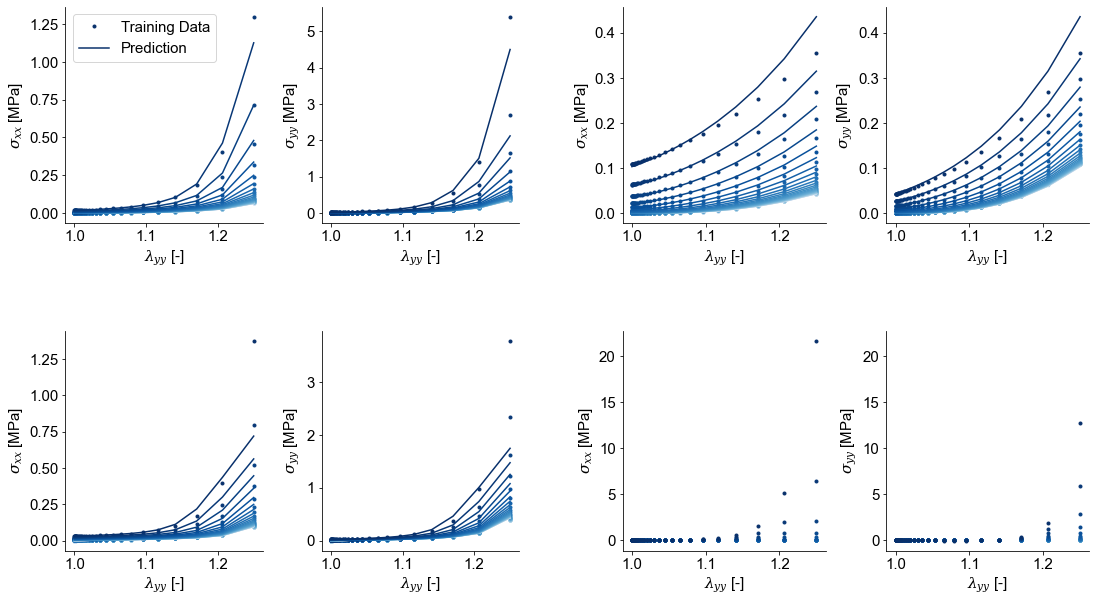

In [5]:
def commonplot(ax, sigma, sigma_pred, stress_id):
    for i in range(res):
        start = i*res-1
        end = (i+1)*res-1
        ax.plot(lamb[start:end,1], sigma[start:end,stress_id], '.')
    for i in range(res):
        start = i*res-1
        end = (i+1)*res-1
        ax.plot(lamb[start:end,1], sigma_pred[start:end,stress_id,stress_id],'-')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    if stress_id == 0:
        ax.set(xlabel='$\lambda_{yy}$ [-]', ylabel = '$\sigma_{xx}$ [MPa]')
    else:
        ax.set(xlabel='$\lambda_{yy}$ [-]', ylabel = '$\sigma_{yy}$ [MPa]')
        
plt.rcParams['axes.prop_cycle'] = plt.cycler('color', plt.cm.Blues(np.linspace(0.1, 1, res)))
matplotlib.rcParams.update({'font.size': 15})
plt.rcParams["mathtext.fontset"] = 'dejavuserif'
plt.rcParams.update({'font.sans-serif':'Arial'})

fig = plt.figure(figsize=(18,10))
#=================== GOH; Top Left =======================%
gs = fig.add_gridspec(1,2, wspace=0.3, hspace=0.2, left = 0.05, right = 0.4, bottom = 0.58)
ax1 = fig.add_subplot(gs[0,0])
ax2 = fig.add_subplot(gs[0,1])

for i in range(res-1):
    start = i*res-1
    end = (i+1)*res-1
    ax1.plot(lamb[start:end,1], sigma_GOH[start:end,0], '.')
i = res
start = i*res
end = (i+1)*res
ax1.plot(lamb[start:end,1], sigma_GOH[start:end,0], '.', label='Training Data')

for i in range(res-1):
    start = i*res-1
    end = (i+1)*res-1
    ax1.plot(lamb[start:end,1], sigma_pred_GOH[start:end,0,0],'-')
i = res
start = i*res
end = (i+1)*res
ax1.plot(lamb[start:end,1], sigma_pred_GOH[start:end,0,0],'-', label='Prediction')

for i in range(res):
    start = i*res-1
    end = (i+1)*res-1
    ax2.plot(lamb[start:end,1], sigma_GOH[start:end,1], '.')
for i in range(res):
    start = i*res-1
    end = (i+1)*res-1
    ax2.plot(lamb[start:end,1], sigma_pred_GOH[start:end,1,1],'-')
    
ax1.set(xlabel='$\lambda_{yy}$ [-]', ylabel = '$\sigma_{xx}$ [MPa]')
ax1.legend()
#ax1.text(1.1,2.1,'                         GOH \nAvg abs error ($E_{abs}$)= %.2e [MPa]' %(np.mean(e_abs_GOH))) #Just absolute error
ax2.set(xlabel='$\lambda_{yy}$ [-]', ylabel = '$\sigma_{yy}$ [MPa]')

ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)

#=================== MR; Top Right =======================%
gs = fig.add_gridspec(1,2, wspace=0.3, hspace=0.2, left = 0.48, right = 0.84, bottom = 0.58)
ax3 = fig.add_subplot(gs[0,0])
ax4 = fig.add_subplot(gs[0,1],sharey=ax3)
commonplot(ax3, sigma_MR, sigma_pred_MR, 0)
commonplot(ax4, sigma_MR, sigma_pred_MR, 1)
#ax3.text(1.21,0.39,' Mooney Rivlin \n$E_{abs}$= %.2e' %(np.mean(e_abs_MR)))

#=================== HGO; Bottom Left =======================%
gs = fig.add_gridspec(1,2, wspace=0.3, hspace=0.2, left = 0.05, right = 0.4, top = 0.43)
ax5 = fig.add_subplot(gs[0,0])
ax6 = fig.add_subplot(gs[0,1])
commonplot(ax5, sigma_HGO, sigma_pred_HGO, 0)
commonplot(ax6, sigma_HGO, sigma_pred_HGO, 1)
#ax5.text(1.2,1.9,'          HGO \n$E_{abs}$= %.2e' %(np.mean(e_abs_HGO)))

#=================== Fung; Bottom Right =======================%
gs = fig.add_gridspec(1,2, wspace=0.3, hspace=0.2, left = 0.48, right = 0.84, top = 0.43)
ax7 = fig.add_subplot(gs[0,0])
ax8 = fig.add_subplot(gs[0,1],sharey=ax7)
commonplot(ax7, sigma_Fung, sigma_pred_Fung, 0)
commonplot(ax8, sigma_Fung, sigma_pred_Fung, 1)
#ax7.text(1.2,24,'         Fung \n$E_{abs}$= %.2e' %(np.mean(e_abs_Fung)))

#fig.savefig('Figures/rfig_synthetic.jpg', dpi=400, bbox_inches='tight')